In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Modules for signal transform
from tsfresh import feature_extraction
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [119]:
# Consts
n_treads = 4 # used in sklearn and tsfresh
n_params = 75 # Params to remain in dataset

In [5]:
def normalize_signal(signal, min_max=False):
    """
    signal - np.array or pd.Series with signal values
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    if signal.name == 'delta':
        return signal / 180
    if min_max:
        return (signal - signal.min()) / (signal.max() - signal.min())
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [6]:
def normalize_all_signals_in_ds(one_group_ds, min_max=1):
    global counter
    counter += 1
    for signal in one_group_ds.drop('t', axis=1):
#         if signal in ['Ug', 'Pg']:
#             one_group_ds[signal] = one_group_ds[signal] / one_group_ds[signal][0] - 1
#         else:
            one_group_ds[signal] = normalize_signal(one_group_ds[signal], min_max)

In [7]:
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [8]:
# labels = pd.DataFrame(columns=['id', 'class', 'label'])
# labels.columns
# labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# # dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

In [9]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None, min_max_norm=True):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
#                 print(f'>>{filename}')
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df, min_max_norm)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset, min_max_norm)
                    signals_dataset['id'] = signal_id
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_dataset, labels

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [10]:
# os.chdir('../')
os.getcwd()

'/home/poligon/master_degree'

In [11]:
# Dataset for first gen
counter = 0
dataset, labels = append_signals_dataset('./data/gen_1_25')
dataset, labels = append_signals_dataset('./data/gen_3_25', dataset, labels)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
dataset_2, labels_2 = append_signals_dataset('./data/gen_1_80')
dataset_2, labels_2 = append_signals_dataset('./data/gen_2_80', dataset_2, labels_2)
dataset_2, labels_2 = append_signals_dataset('./data/gen_3_80', dataset_2, labels_2)

In [12]:
labelizer = LabelEncoder().fit(labels['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    labels_df['label'] = labelizer.transform(labels_df['class'])
    labels_df.index = labels_df['id']
    labels_df.drop(columns=['id'])

In [13]:
labels_2.label.value_counts()

1    76
2    50
0    45
Name: label, dtype: int64

In [14]:
print("Уникальные классы в датасете:", np.unique(labels['class']))
normalize_labels(labels)
normalize_labels(labels_2)
labels.sample(5)

Уникальные классы в датасете: ['le_8' 'more_20' 'more_8']


,id,class,label
id,,,
8,8,more_20,1
65,65,more_20,1
64,64,more_20,1
4,4,more_20,1
58,58,more_20,1


In [15]:
dataset.isna().sum()

t            0
Ug           0
Us           0
Pij          0
Pg           0
Pgt      20200
delta        0
id           0
dtype: int64

In [16]:
dataset.columns

Index(['t', 'Ug', 'Us', 'Pij', 'Pg', 'Pgt', 'delta', 'id'], dtype='object')

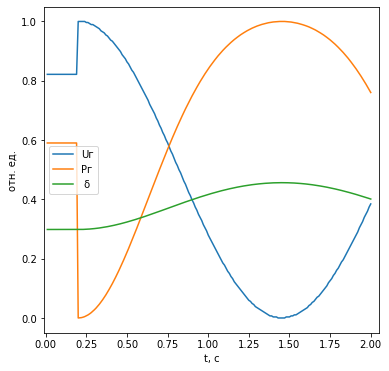

In [17]:
ex = dataset.query('id == 35')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
x_label = 't, с'
plt.plot(ex['t'], ex['Ug'], label='Uг')
plt.plot(ex['t'], ex['Pg'], label='Pг')
plt.plot(ex['t'], ex['delta'], label=' δ')
plt.xlim(-0.01, 2.05)
plt.xlabel(x_label)
plt.ylabel('отн. ед.')
plt.legend(loc='best')

plt.show()

In [18]:
# Удалим колонки которые не несут достаточной информации (повторяют значения, не изменяются)
# или могут быть некорректны
def drop_columns(dataset):
    mod_dataset = dataset.drop(['Us', 'Pgt', 'Pij'], axis=1)
    mod_dataset.index.name = 'tmp_id'
    return mod_dataset
mod_dataset = drop_columns(dataset)
mod_dataset_2 = drop_columns(dataset_2)
# Проверим возможность склеить сигнал с метками
mod_dataset.head(5)

,t,Ug,Pg,delta,id
tmp_id,,,,,
0,0.01,0.786561,0.575077,0.282944,0
1,0.02,0.786561,0.575077,0.282944,0
2,0.03,0.786561,0.575077,0.282944,0
3,0.04,0.786561,0.575077,0.282944,0
4,0.05,0.786561,0.575077,0.282944,0


In [19]:
def extract_signal_features(df, labels_df, feat_selection=True, signal_list=['Ug', 'Pg', 'delta']):
    features = defaultdict()
    for param in signal_list:
#     mod_dataset[param] = mod_dataset[param].astype('float')
        features[param] = feature_extraction.extract_features\
        (df.loc[:,[param,'id','t']], column_sort='t', column_id='id', n_jobs=n_treads)
        impute(features[param])
        if feat_selection:
            features[param] = select_features(features[param], labels_df['label'], ml_task='classification', n_jobs=n_treads)
    return features

In [20]:
features = extract_signal_features(mod_dataset, labels)

Feature Extraction: 100%|██████████| 17/17 [01:04<00:00,  3.81s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['delta__friedrich_coefficients__m_3__r_30__coeff_0'
 'delta__friedrich_coefficients__m_3__r_30__coeff_1'
 'delta__friedrich_coefficients__m_3__r_30__coeff_2'
 'delta__friedrich_coefficients__m_3__r_30__coeff_3'
 'delta__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Извлечем те же признаки для проверочного датасета, который модель никогда не видела

In [21]:
features_val = extract_signal_features(mod_dataset_2, labels_2, False)

Feature Extraction: 100%|██████████| 19/19 [01:46<00:00,  5.60s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['delta__friedrich_coefficients__m_3__r_30__coeff_0'
 'delta__friedrich_coefficients__m_3__r_30__coeff_1'
 'delta__friedrich_coefficients__m_3__r_30__coeff_2'
 'delta__friedrich_coefficients__m_3__r_30__coeff_3'
 'delta__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


### Отбор признаков и формирование эквивалентных датасетов
После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)

В конечном счете для каждого сигнала сформирован следующий набор данных:

In [120]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра Ug получено 541 признака(ов).
Для параметра Pg получено 609 признака(ов).
Для параметра delta получено 670 признака(ов).


In [121]:
# Пример хранящихся признаков
features['Ug'].columns.values[np.random\
                              .randint(0, 
                                       features['Ug'].shape[1],
                                       20)]

array(['Ug__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'Ug__fft_coefficient__coeff_16__attr_"abs"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2',
       'Ug__fft_coefficient__coeff_98__attr_"real"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_10',
       'Ug__fft_coefficient__coeff_3__attr_"imag"',
       'Ug__fft_coefficient__coeff_98__attr_"real"',
       'Ug__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'Ug__fft_coefficient__coeff_55__attr_"real"',
       'Ug__fft_coefficient__coeff_41__attr_"abs"',
       'Ug__autocorrelation__lag_6',
       'Ug__fft_coefficient__coeff_1__attr_"real"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2',
       'Ug__fft_coefficient__coeff_39__attr_"real"',
       'Ug__fft_coefficient__coeff_23__attr_"real"',
       'Ug__fft_coefficient__coeff_87__attr_"abs"',
       'Ug__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
       'Ug__chan

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [122]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=3):
    for feature in features.columns:
        if features[feature].nunique() <= threshold \
            or features[feature].isna().sum():
            features = features.drop(feature, axis=1)
    return features

In [123]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для Ug: 6
Число удаленных признаков для Pg: 9
Число удаленных признаков для delta: 8


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [124]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [125]:
# X = delete_negative_features(modified_features['U'])
# X_2 = 
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [126]:
def plot_features(X, y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=200)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.xlabel('Оценка значимоссти')
    plt.ylabel('Переменная')
    plt.show()
    return feat_importances.nlargest(n_params)

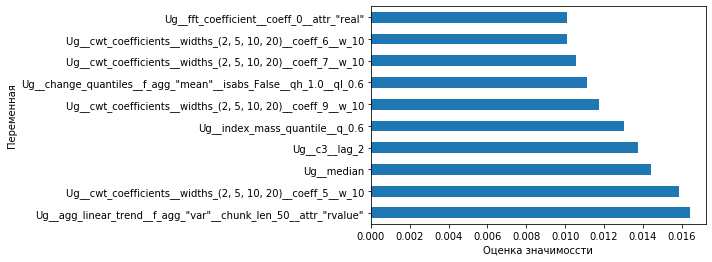

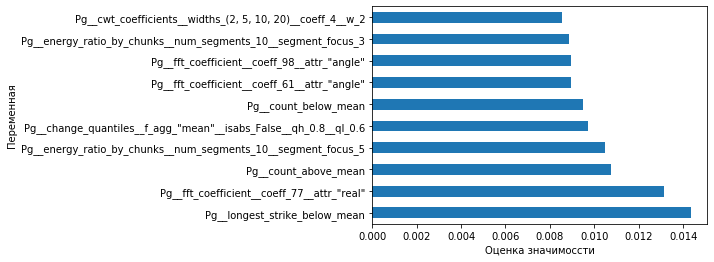

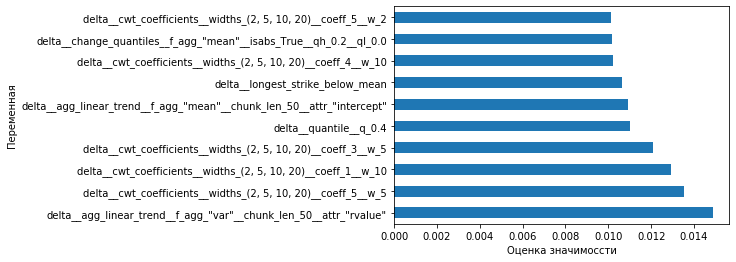

In [127]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param].astype('float32'), labels.label))

In [128]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
def remain_relevant_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            if feat in most_valuable_feat[param]:
#                 if most_valuable_feat[param][feat] >= 0.008:
                    resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [129]:
def join_signal_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [130]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,"Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10","Ug__fft_coefficient__coeff_19__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10","Ug__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","Ug__fft_coefficient__coeff_3__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10","Ug__fft_coefficient__coeff_3__attr_""angle""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20",...,delta__approximate_entropy__m_2__r_0.5,delta__approximate_entropy__m_2__r_0.9,delta__approximate_entropy__m_2__r_0.7,"delta__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""",delta__longest_strike_below_mean,delta__count_below_mean,delta__longest_strike_above_mean,delta__number_cwt_peaks__n_1
id,,,,,,,,,,,,,,,,,,,,,
0,0.657114,0.755949,0.769167,-0.431112,-1.734249,0.522359,-102.385873,0.857243,-0.384502,-0.219759,...,0.007152,0.004227,0.005399,-0.047492,-0.045574,-0.048526,98.0,98.0,102.0,28.0
1,0.606452,0.761108,0.713753,-0.539858,-1.771619,0.477404,-103.610867,0.798188,-0.421613,-0.259567,...,0.007898,0.004849,0.006066,-0.074915,-0.077398,-0.094158,97.0,97.0,103.0,31.0


In [131]:
print("Оставшиеся фичи:")
print(*resulted_df.columns[:10], sep='\n')

Оставшиеся фичи:
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10
Ug__fft_coefficient__coeff_19__attr_"real"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10
Ug__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"
Ug__fft_coefficient__coeff_3__attr_"real"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10
Ug__fft_coefficient__coeff_3__attr_"angle"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20


## Постоение простейших моделей, градиентный бустинг и ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [132]:
# OVA strategy
from sklearn.multiclass import OneVsRestClassifier
# OVO strategy
from sklearn.multiclass import OneVsOneClassifier
# Estimators for use in OVR (OVA)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Estimators with built-in OVR
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Sklearn metrics
from sklearn import metrics
# Defaultdict
from collections import defaultdict

In [133]:
X = resulted_df
y = labels.label

In [134]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [135]:
resulted_df_val = join_signal_features(features_val).reindex(columns=X.columns)
X_test, y_test = resulted_df_val, labels_2.label

## Class for model evaluating

In [136]:
class ModelEvaluator():
    strategy_list = {'ovr': OneVsRestClassifier,
                     'ovo': OneVsRestClassifier}
    metric_list = {'F1 macro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='macro'),
                   'F1 micro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='micro'),
                   'Accuracy': metrics.accuracy_score,
                   }
    
    def __init__(self, clf, strategy='ovr', n_jobs=4):
        """
        clf - classifier with fit, predict and predict_proba methods (classic)
        X_train, y_train - training dataset
        X_test, y_test - test dataset
        strategy - multiclasss Strategy OVO/OVR
        """
        if strategy.lower() not in self.strategy_list:
            raise AttributeError('Strategy must be OVR or OVO')
        self.strategy = strategy
        self.clf = self.strategy_list[strategy.lower()](clf, n_jobs)
        self.conf_matrix = None
        self.metrics = defaultdict()
    
    def count_metrics(self, y_true, y_pred):
        for metric_name, metric_func in self.metric_list.items():
            self.metrics[metric_name] = metric_func(y_true, y_pred)
    
    def evaluate(self, X_train, y_train, X_test, y_test, output=False):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        self.conf_matrix = metrics.confusion_matrix(y_test, y_pred)
        self.count_metrics(y_test, y_pred)
        if output: print(*self.metrics.items(), sep='\n')
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def predict_proba(self, X):
        if self.strategy == 'ovo':
            raise AttributeError('OVO strategy has no predict_proba!')
        return self.clf.predict_proba(X)
    
    def __repr__(self):
        sep = '-' * 10 + '\n'
        res = ''
        res += f'Strategy {self.strategy} with estimator:\n'
        res += str(self.clf.estimator) + '\n'
        res += sep
        if self.conf_matrix is not None:
            res += f'Confusion matrix:\n{self.conf_matrix}\n'
            res += sep
            res += '\n'.join([' '.join(list(map(str, pair))) for pair in self.metrics.items()])
        else:
            res += 'Model is not fitted'
        return res

### AdaBoost

In [137]:
ada = AdaBoostClassifier(n_estimators=110)

In [138]:
ada_ev = ModelEvaluator(ada)

In [139]:
ada_ev.evaluate(X, y, X_test, y_test)
ada_ev

Strategy ovr with estimator:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=110, random_state=None)
----------
Confusion matrix:
[[24  0 26]
 [ 0 12 33]
 [10  9 57]]
----------
F1 macro 0.5096049783549783
F1 micro 0.543859649122807
Accuracy 0.543859649122807

### Naive Bayes

In [140]:
gnb = GaussianNB()

In [141]:
gnb_ev = ModelEvaluator(gnb)

In [142]:
gnb_ev.evaluate(X, y, X_test, y_test)
gnb_ev

Strategy ovr with estimator:
GaussianNB(priors=None, var_smoothing=1e-09)
----------
Confusion matrix:
[[47  0  3]
 [ 0 15 30]
 [ 6  4 66]]
----------
F1 macro 0.7118856911696717
F1 micro 0.7485380116959063
Accuracy 0.7485380116959064

### SVM (SVC)

In [143]:
svm_clf = SVC()

In [144]:
svm_ev = ModelEvaluator(svm_clf)

In [145]:
svm_ev.evaluate(X, y, X_test, y_test)
svm_ev

Strategy ovr with estimator:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
----------
Confusion matrix:
[[35  0 15]
 [15  0 30]
 [19  0 57]]
----------
F1 macro 0.4095615774399648
F1 micro 0.5380116959064327
Accuracy 0.5380116959064327

### GaussianProcess

In [146]:
gpc = GaussianProcessClassifier(multi_class = 'one_vs_one',
                                max_iter_predict=100
                               )
clf = gpc

In [147]:
clf.fit(X, y)

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_one', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [148]:
y_pred = clf.predict(X_test)

In [149]:
y_true = np.array(y_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("F1-macro:", metrics.f1_score(y_true, y_pred, average='macro'))
metrics.confusion_matrix(y_true, y_pred)

Accuracy: 0.5964912280701754
F1-macro: 0.568560507834018


array([[47,  0,  3],
       [15, 15, 15],
       [25, 11, 40]])

### Ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [150]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_depth=5,
                             max_features='auto',
                             class_weight='balanced',
#                              bootstrap=False
                            )

In [151]:
rfc_ev = ModelEvaluator(rfc)

In [153]:
rfc_ev.evaluate(X, y, X_test, y_test)
rfc_ev

Strategy ovr with estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
----------
Confusion matrix:
[[38  0 12]
 [ 0  4 41]
 [ 0  9 67]]
----------
F1 macro 0.5617469558356257
F1 micro 0.6374269005847953
Accuracy 0.6374269005847953

### Градиентный бустинг

In [154]:
gbc = GradientBoostingClassifier(learning_rate=0.01,
                                 random_state=42,
                                 n_estimators=500,
                                 min_samples_leaf=3,
                                 max_depth=3)

In [155]:
gbc_ev = ModelEvaluator(gbc)

In [156]:
gbc_ev.evaluate(X, y, X_test, y_test)
gbc_ev

Strategy ovr with estimator:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
----------
Confusion matrix:
[[35  0 15]
 [ 0  7 38]
 [10  9 57]]
----------
F1 macro 0.5264178425969737
F1 micro 0.5789473684210527
Accuracy 0.5789473684210527

### CatBoost

In [157]:
from catboost import CatBoostClassifier

In [200]:
cboost_clf = CatBoostClassifier(
                                n_estimators=500,
                                max_depth=2,
                                learning_rate=0.05,
                                loss_function='MultiClass',
                                random_state=4
                                )

In [201]:
cboost_ev = ModelEvaluator(cboost_clf)
clf = cboost_clf

In [202]:
cboost_ev.evaluate(X, y, X_test, y_test)

In [203]:
cboost_ev

Strategy ovr with estimator:
----------
Confusion matrix:
[[41  0  9]
 [ 0 15 30]
 [ 3  9 64]]
----------
F1 macro 0.6740689443700828
F1 micro 0.7017543859649122
Accuracy 0.7017543859649122

In [190]:
clf = CatBoostClassifier(
                                n_estimators=700,
                                max_depth=3,
                                learning_rate=0.063,
                                loss_function='MultiClass',
                                random_state=42
                                )

In [64]:
# For searching optimal params
clf.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 1.0360761	test: 1.0290912	best: 1.0290912 (0)	total: 86.4ms	remaining: 1m
1:	learn: 0.9609966	test: 0.9485136	best: 0.9485136 (1)	total: 109ms	remaining: 38.2s
2:	learn: 0.9055330	test: 0.8887445	best: 0.8887445 (2)	total: 138ms	remaining: 32s
3:	learn: 0.8454204	test: 0.8259301	best: 0.8259301 (3)	total: 162ms	remaining: 28.2s
4:	learn: 0.8006856	test: 0.7728981	best: 0.7728981 (4)	total: 188ms	remaining: 26.2s
5:	learn: 0.7629418	test: 0.7346438	best: 0.7346438 (5)	total: 212ms	remaining: 24.5s
6:	learn: 0.7220805	test: 0.6877881	best: 0.6877881 (6)	total: 245ms	remaining: 24.2s
7:	learn: 0.6832742	test: 0.6463077	best: 0.6463077 (7)	total: 273ms	remaining: 23.6s
8:	learn: 0.6478579	test: 0.6079727	best: 0.6079727 (8)	total: 301ms	remaining: 23.1s
9:	learn: 0.6127747	test: 0.5699622	best: 0.5699622 (9)	total: 335ms	remaining: 23.1s
10:	learn: 0.5795793	test: 0.5332589	best: 0.5332589 (10)	total: 377ms	remaining: 23.6s
11:	learn: 0.5589349	test: 0.5112856	best: 0.5112856 (11

98:	learn: 0.0541475	test: 0.0328745	best: 0.0328745 (98)	total: 3.35s	remaining: 20.3s
99:	learn: 0.0532805	test: 0.0322427	best: 0.0322427 (99)	total: 3.39s	remaining: 20.3s
100:	learn: 0.0521826	test: 0.0315955	best: 0.0315955 (100)	total: 3.42s	remaining: 20.3s
101:	learn: 0.0513151	test: 0.0310335	best: 0.0310335 (101)	total: 3.45s	remaining: 20.2s
102:	learn: 0.0505357	test: 0.0304796	best: 0.0304796 (102)	total: 3.47s	remaining: 20.1s
103:	learn: 0.0496939	test: 0.0299114	best: 0.0299114 (103)	total: 3.5s	remaining: 20.1s
104:	learn: 0.0487038	test: 0.0293124	best: 0.0293124 (104)	total: 3.53s	remaining: 20s
105:	learn: 0.0478176	test: 0.0286928	best: 0.0286928 (105)	total: 3.56s	remaining: 20s
106:	learn: 0.0471759	test: 0.0283502	best: 0.0283502 (106)	total: 3.61s	remaining: 20s
107:	learn: 0.0467601	test: 0.0280800	best: 0.0280800 (107)	total: 3.63s	remaining: 19.9s
108:	learn: 0.0461604	test: 0.0276503	best: 0.0276503 (108)	total: 3.66s	remaining: 19.9s
109:	learn: 0.0454343

195:	learn: 0.0195422	test: 0.0115564	best: 0.0115564 (195)	total: 6.21s	remaining: 16s
196:	learn: 0.0193718	test: 0.0114314	best: 0.0114314 (196)	total: 6.24s	remaining: 15.9s
197:	learn: 0.0193474	test: 0.0114155	best: 0.0114155 (197)	total: 6.27s	remaining: 15.9s
198:	learn: 0.0192281	test: 0.0113481	best: 0.0113481 (198)	total: 6.3s	remaining: 15.9s
199:	learn: 0.0190281	test: 0.0112141	best: 0.0112141 (199)	total: 6.32s	remaining: 15.8s
200:	learn: 0.0189331	test: 0.0111411	best: 0.0111411 (200)	total: 6.35s	remaining: 15.8s
201:	learn: 0.0187828	test: 0.0110501	best: 0.0110501 (201)	total: 6.38s	remaining: 15.7s
202:	learn: 0.0187470	test: 0.0110362	best: 0.0110362 (202)	total: 6.42s	remaining: 15.7s
203:	learn: 0.0185621	test: 0.0109172	best: 0.0109172 (203)	total: 6.46s	remaining: 15.7s
204:	learn: 0.0184218	test: 0.0108260	best: 0.0108260 (204)	total: 6.49s	remaining: 15.7s
205:	learn: 0.0184081	test: 0.0108253	best: 0.0108253 (205)	total: 6.51s	remaining: 15.6s
206:	learn: 0

289:	learn: 0.0118084	test: 0.0069992	best: 0.0069992 (289)	total: 9.03s	remaining: 12.8s
290:	learn: 0.0118007	test: 0.0069929	best: 0.0069929 (290)	total: 9.06s	remaining: 12.7s
291:	learn: 0.0117387	test: 0.0069552	best: 0.0069552 (291)	total: 9.12s	remaining: 12.7s
292:	learn: 0.0116795	test: 0.0069236	best: 0.0069236 (292)	total: 9.14s	remaining: 12.7s
293:	learn: 0.0116242	test: 0.0068920	best: 0.0068920 (293)	total: 9.16s	remaining: 12.7s
294:	learn: 0.0116169	test: 0.0068915	best: 0.0068915 (294)	total: 9.2s	remaining: 12.6s
295:	learn: 0.0115719	test: 0.0068639	best: 0.0068639 (295)	total: 9.22s	remaining: 12.6s
296:	learn: 0.0115654	test: 0.0068632	best: 0.0068632 (296)	total: 9.26s	remaining: 12.6s
297:	learn: 0.0114797	test: 0.0068073	best: 0.0068073 (297)	total: 9.3s	remaining: 12.5s
298:	learn: 0.0114179	test: 0.0067663	best: 0.0067663 (298)	total: 9.33s	remaining: 12.5s
299:	learn: 0.0113597	test: 0.0067310	best: 0.0067310 (299)	total: 9.35s	remaining: 12.5s
300:	learn: 

386:	learn: 0.0084453	test: 0.0049865	best: 0.0049865 (386)	total: 12.5s	remaining: 10.1s
387:	learn: 0.0084131	test: 0.0049613	best: 0.0049613 (387)	total: 12.6s	remaining: 10.1s
388:	learn: 0.0084093	test: 0.0049609	best: 0.0049609 (388)	total: 12.6s	remaining: 10.1s
389:	learn: 0.0083768	test: 0.0049413	best: 0.0049413 (389)	total: 12.6s	remaining: 10s
390:	learn: 0.0083704	test: 0.0049413	best: 0.0049413 (389)	total: 12.7s	remaining: 10s
391:	learn: 0.0083386	test: 0.0049213	best: 0.0049213 (391)	total: 12.7s	remaining: 9.97s
392:	learn: 0.0082976	test: 0.0048933	best: 0.0048933 (392)	total: 12.7s	remaining: 9.94s
393:	learn: 0.0082927	test: 0.0048931	best: 0.0048931 (393)	total: 12.8s	remaining: 9.9s
394:	learn: 0.0082585	test: 0.0048719	best: 0.0048719 (394)	total: 12.8s	remaining: 9.88s
395:	learn: 0.0082115	test: 0.0048469	best: 0.0048469 (395)	total: 12.8s	remaining: 9.85s
396:	learn: 0.0081645	test: 0.0048197	best: 0.0048197 (396)	total: 12.9s	remaining: 9.81s
397:	learn: 0.0

482:	learn: 0.0064075	test: 0.0037829	best: 0.0037829 (482)	total: 15.7s	remaining: 7.06s
483:	learn: 0.0063965	test: 0.0037758	best: 0.0037758 (483)	total: 15.7s	remaining: 7.03s
484:	learn: 0.0063929	test: 0.0037758	best: 0.0037758 (484)	total: 15.8s	remaining: 6.99s
485:	learn: 0.0063739	test: 0.0037640	best: 0.0037640 (485)	total: 15.8s	remaining: 6.96s
486:	learn: 0.0063717	test: 0.0037638	best: 0.0037638 (486)	total: 15.8s	remaining: 6.93s
487:	learn: 0.0063697	test: 0.0037636	best: 0.0037636 (487)	total: 15.9s	remaining: 6.9s
488:	learn: 0.0063565	test: 0.0037551	best: 0.0037551 (488)	total: 15.9s	remaining: 6.88s
489:	learn: 0.0063428	test: 0.0037465	best: 0.0037465 (489)	total: 16s	remaining: 6.85s
490:	learn: 0.0063254	test: 0.0037369	best: 0.0037369 (490)	total: 16s	remaining: 6.82s
491:	learn: 0.0063119	test: 0.0037261	best: 0.0037261 (491)	total: 16s	remaining: 6.78s
492:	learn: 0.0063011	test: 0.0037171	best: 0.0037171 (492)	total: 16.1s	remaining: 6.75s
493:	learn: 0.006

574:	learn: 0.0052664	test: 0.0031084	best: 0.0031084 (574)	total: 19.1s	remaining: 4.15s
575:	learn: 0.0052492	test: 0.0030973	best: 0.0030973 (575)	total: 19.1s	remaining: 4.12s
576:	learn: 0.0052374	test: 0.0030914	best: 0.0030914 (576)	total: 19.2s	remaining: 4.09s
577:	learn: 0.0052265	test: 0.0030855	best: 0.0030855 (577)	total: 19.2s	remaining: 4.06s
578:	learn: 0.0052137	test: 0.0030774	best: 0.0030774 (578)	total: 19.3s	remaining: 4.03s
579:	learn: 0.0052028	test: 0.0030738	best: 0.0030738 (579)	total: 19.3s	remaining: 4s
580:	learn: 0.0051835	test: 0.0030626	best: 0.0030626 (580)	total: 19.4s	remaining: 3.97s
581:	learn: 0.0051694	test: 0.0030542	best: 0.0030542 (581)	total: 19.4s	remaining: 3.94s
582:	learn: 0.0051568	test: 0.0030466	best: 0.0030466 (582)	total: 19.5s	remaining: 3.91s
583:	learn: 0.0051458	test: 0.0030403	best: 0.0030403 (583)	total: 19.5s	remaining: 3.87s
584:	learn: 0.0051295	test: 0.0030313	best: 0.0030313 (584)	total: 19.6s	remaining: 3.84s
585:	learn: 0

670:	learn: 0.0043991	test: 0.0026104	best: 0.0026104 (670)	total: 22.4s	remaining: 968ms
671:	learn: 0.0043939	test: 0.0026069	best: 0.0026069 (671)	total: 22.5s	remaining: 936ms
672:	learn: 0.0043864	test: 0.0026026	best: 0.0026026 (672)	total: 22.5s	remaining: 902ms
673:	learn: 0.0043742	test: 0.0025959	best: 0.0025959 (673)	total: 22.5s	remaining: 868ms
674:	learn: 0.0043638	test: 0.0025900	best: 0.0025900 (674)	total: 22.5s	remaining: 835ms
675:	learn: 0.0043555	test: 0.0025849	best: 0.0025849 (675)	total: 22.6s	remaining: 801ms
676:	learn: 0.0043475	test: 0.0025804	best: 0.0025804 (676)	total: 22.6s	remaining: 768ms
677:	learn: 0.0043462	test: 0.0025796	best: 0.0025796 (677)	total: 22.6s	remaining: 734ms
678:	learn: 0.0043360	test: 0.0025744	best: 0.0025744 (678)	total: 22.7s	remaining: 701ms
679:	learn: 0.0043281	test: 0.0025697	best: 0.0025697 (679)	total: 22.7s	remaining: 669ms
680:	learn: 0.0043216	test: 0.0025661	best: 0.0025661 (680)	total: 22.8s	remaining: 635ms
681:	learn

In [65]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
metrics.confusion_matrix(y_true, clf.predict(X_test))

Accuracy: 0.672514619883041


array([[39,  0, 11],
       [ 0, 15, 30],
       [ 6,  9, 61]])

In [66]:
clf = cboost_ev

In [67]:
predicted_labels = labelizer.inverse_transform(clf.predict(X_test)).reshape(-1,1)
predicted_df = pd.DataFrame(np.concatenate([predicted_labels, clf.predict_proba(X_test)], axis=1),
                            index=labels_2.index,
                            columns=['predicted_class'] + list(labelizer.classes_),
                           )
pd.concat(
          [labels_2,
           predicted_df
          ],
          axis=1).sample(10)

,id,class,label,predicted_class,le_8,more_20,more_8
id,,,,,,,
126,126,more_8,2,more_8,0.406774,0.00195406,0.591272
4,4,more_20,1,more_20,0.00225557,0.706967,0.290778
59,59,more_20,1,more_8,0.0019366,0.235572,0.762491
129,129,more_8,2,more_8,0.0299204,0.00797385,0.962106
60,60,more_20,1,more_8,0.00178214,0.233548,0.76467
105,105,le_8,0,le_8,0.990509,0.00381133,0.00567962
44,44,le_8,0,more_8,0.472633,0.0028351,0.524532
10,10,more_20,1,more_20,0.00225752,0.706713,0.291029
84,84,more_8,2,more_8,0.0267604,0.00534608,0.967894


In [68]:
clf.predict(X_val).reshape(1,-1)

array([[2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2]])

In [69]:
y_val.values

array([2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2])

In [70]:
labelizer.classes_[1]

'more_20'

Гит комит

In [71]:
# !git status
# !git add .
# !git commit -m "Added another generator"
